# Generación de puntos de ausencia y preparación de dataset para regresión logística

Este notebook genera puntos pseudo-ausencia (flood=0), etiqueta los puntos de inundación históricos (flood=1) y consolida el dataset para regresión logística de susceptibilidad.

## 1. Importar librerías y definir rutas de archivo

In [10]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from shapely.geometry import Point
import rasterio
from rasterio import features
from rasterio.errors import RasterioIOError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, auc
# Ajusta estas rutas a la ubicación de tus archivos
CITY_SHP = "D:\Semestre 2025-1\Analisis Geoespacial\SHP\ZonaUrbana_Medellin.shp"  # Polígono urbano de Medellín
PRESENCE_SHP = "D:\Semestre 2025-1\Analisis Geoespacial\SHP\Inventario_inundaciones_lluvias_MedellinZonaUrbana.shp"  # Puntos de inundación históricos


<>:18: SyntaxWarning: invalid escape sequence '\S'
<>:19: SyntaxWarning: invalid escape sequence '\S'
<>:18: SyntaxWarning: invalid escape sequence '\S'
<>:19: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Usuario\AppData\Local\Temp\ipykernel_82288\1008554771.py:18: SyntaxWarning: invalid escape sequence '\S'
  CITY_SHP = "D:\Semestre 2025-1\Analisis Geoespacial\SHP\ZonaUrbana_Medellin.shp"  # Polígono urbano de Medellín
C:\Users\Usuario\AppData\Local\Temp\ipykernel_82288\1008554771.py:19: SyntaxWarning: invalid escape sequence '\S'
  PRESENCE_SHP = "D:\Semestre 2025-1\Analisis Geoespacial\SHP\Inventario_inundaciones_lluvias_MedellinZonaUrbana.shp"  # Puntos de inundación históricos


## 2. Cargar y reproyectar datos

In [2]:
# Cargar ciudad y reproyectar a CRS métrico (EPSG:9377)
gdf_city = gpd.read_file(CITY_SHP).to_crs(epsg=9377)

# Cargar puntos de presencia y asignar flood=1
gdf_pos = gpd.read_file(PRESENCE_SHP).to_crs(epsg=9377)
gdf_pos["flood"] = 1

print(f"Número de puntos de presencia: {len(gdf_pos)}")


Número de puntos de presencia: 430


## 3. Generar puntos pseudo-ausencia (flood=0) (buffer de 50 m)

In [5]:
# Parámetros de muestreo
n_pres = len(gdf_pos)*5
n_abs = n_pres  # ratio 1:5
minx, miny, maxx, maxy = gdf_city.total_bounds

np.random.seed(42)
abs_pts = []
buffers = gdf_pos.buffer(50)

while len(abs_pts) < n_abs:
    x = np.random.uniform(minx, maxx)
    y = np.random.uniform(miny, maxy)
    p = Point(x, y)
    # 1) Debe caer en Medellín
    if not gdf_city.contains(p).any():
        continue
    # 2) No puede caer en un buffer de 50 m alrededor de presencias
    if any(p.within(buf) for buf in buffers):
        continue
    abs_pts.append(p)

gdf_abs = gpd.GeoDataFrame(geometry=abs_pts, crs=gdf_city.crs)
print(f"Puntos de ausencia definitivos: {len(gdf_abs)}")


Puntos de ausencia definitivos: 2150


## 5. Consolidar dataset y etiquetar

In [35]:
# Etiquetar ausencias
gdf_abs["flood"] = 0

# Concatenar presencias y ausencias
gdf_all = gpd.GeoDataFrame(
    pd.concat([gdf_pos, gdf_abs], ignore_index=True),
    crs=gdf_city.crs
)

# Guardar resultado
output_path = "D:\Semestre 2025-1\Analisis Geoespacial\SHP\dataset_susceptibilidad.shp"
gdf_all.to_file(output_path)
print(f"Dataset consolidado con {len(gdf_all)} puntos. Guardado en '{output_path}'.")


Dataset consolidado con 2580 puntos. Guardado en 'D:\Semestre 2025-1\Analisis Geoespacial\SHP\dataset_susceptibilidad.shp'.


<>:11: SyntaxWarning: invalid escape sequence '\S'
<>:11: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Usuario\AppData\Local\Temp\ipykernel_78236\2374930243.py:11: SyntaxWarning: invalid escape sequence '\S'
  output_path = "D:\Semestre 2025-1\Analisis Geoespacial\SHP\dataset_susceptibilidad.shp"


## 6. Incorporar cobertura de uso de suelo

In [36]:
# --- 6. Incorporar cobertura de uso de suelo (ONE-HOT BINARIO) ---
# 6.1. Leer y unificar CRS
gdf_cover = (
    gpd.read_file(r"D:\Semestre 2025-1\Analisis Geoespacial\SHP\Coberturas_MedellinZonaUrbana.shp")
       .to_crs(gdf_all.crs)
       .rename(columns={"tipo":"cover_type"})        # renombrar para evitar confusiones
)

# 6.2. Spatial join para traer cover_type a cada punto
gdf_all = (
    gpd.sjoin(
        gdf_all,
        gdf_cover[["cover_type","geometry"]],
        how="left",
        predicate="within"
    )
    .drop(columns=["index_right"])  # ya no necesitamos el índice del shapefile
)

# 6.3. Asegurar que no queden NaN en cover_type
# (en tu caso esto no debería ocurrir porque toda la ciudad está cubierta)
gdf_all["cover_type"] = gdf_all["cover_type"].fillna("SinCobertura")

# 6.4. One-hot encoding **completo** para cada tipo de cobertura
cover_dummies = pd.get_dummies(
    gdf_all["cover_type"],
    prefix="cover",
    drop_first=False,   # mantenemos una columna por cada clase
    dtype=int
)

# 6.5. Concatenar al GeoDataFrame y eliminar la columna original
gdf_all = pd.concat(
    [gdf_all.drop(columns=["cover_type"]), cover_dummies],
    axis=1
)

print("Coberturas binarizadas:", cover_dummies.columns.tolist())
print("Recuento por tipo de cobertura:\n", cover_dummies.sum(), "\n")

Coberturas binarizadas: ['cover_Bosques y Áreas Seminaturales', 'cover_Superficies de Agua', 'cover_Territorios Agrícolas', 'cover_Territorios Artificializados']
Recuento por tipo de cobertura:
 cover_Bosques y Áreas Seminaturales     678
cover_Superficies de Agua                 8
cover_Territorios Agrícolas             121
cover_Territorios Artificializados     1773
dtype: int64 



## 7. Muestreo de rásteres para añadir variables de terreno

In [37]:
# 7.1 Ruta a cada ráster (ajusta a tus rutas)
raster_files = {
    'elevation': r'D:\Semestre 2025-1\Analisis Geoespacial\Raster\DEM_MedellinZonaUrbana.tif',
    'slope':     r'D:\Semestre 2025-1\Analisis Geoespacial\Raster\Pendientes.tif',
    'aspect':    r'D:\Semestre 2025-1\Analisis Geoespacial\Raster\Aspecto.tif',
    'curvature': r'D:\Semestre 2025-1\Analisis Geoespacial\Raster\Curvatura.tif',
    'TPI':       r'D:\Semestre 2025-1\Analisis Geoespacial\Raster\Topographic Position Index.tif',
    'TRI':       r'D:\Semestre 2025-1\Analisis Geoespacial\Raster\Terrain Ruggedness Index (TRI).tif'
}

# 7.2 Prepara la lista de coordenadas (en el CRS de gdf_all, p.ej EPSG:9377)
coords = [(pt.x, pt.y) for pt in gdf_all.geometry]

# 7.3 Para cada variable, abre el ráster y samplea en los puntos
for var, path in raster_files.items():
    try:
        with rasterio.open(path) as src:
            # lee el primer bando de cada muestra
            values = [val[0] for val in src.sample(coords)]
        gdf_all[var] = values
        print(f"✔  Muestreado {var} en {len(values)} puntos")
    except RasterioIOError:
        print(f"✘ No encontré el ráster: {path}")

# 7.4 Comprueba que todas las variables entraron
print("\nColumnas finales en gdf_all:")
print(gdf_all.columns.tolist())
print("\nPrimeras filas:")
display(gdf_all.head())


✔  Muestreado elevation en 2580 puntos
✔  Muestreado slope en 2580 puntos
✔  Muestreado aspect en 2580 puntos
✔  Muestreado curvature en 2580 puntos
✔  Muestreado TPI en 2580 puntos
✔  Muestreado TRI en 2580 puntos

Columnas finales en gdf_all:
['Unnamed_ 0', '_id', 'Unnamed_ 2', 'date', 'type', 'subregion', 'town', 'county', 'site', 'fatalities', 'losses', 'source', 'add', 'uncertaint', 'created_at', 'updated_at', '__v', 'triggering', 'triggeri_1', 'lon', 'lat', 'geometry', 'flood', 'cover_Bosques y Áreas Seminaturales', 'cover_Superficies de Agua', 'cover_Territorios Agrícolas', 'cover_Territorios Artificializados', 'elevation', 'slope', 'aspect', 'curvature', 'TPI', 'TRI']

Primeras filas:


,Unnamed_ 0,_id,Unnamed_ 2,date,type,subregion,town,county,site,fatalities,...,cover_Bosques y Áreas Seminaturales,cover_Superficies de Agua,cover_Territorios Agrícolas,cover_Territorios Artificializados,elevation,slope,aspect,curvature,TPI,TRI
0,8125.0,5f5652c36f9d0415f2ff6c1b,8060.0,2018-11-03 00:00:00,Flood,Valle de Aburr�,Medell�n,Manrique Oriental,Calle 85 entre las Carreras 39 y la 44.,0.0,...,1,0,0,0,1713.930054,25.336325,260.888000,-0.022461,-7.666822,0.599577
1,8115.0,5f5652c06f9d0415f2ff69d2,7815.0,2008-08-26 00:00:00,Flood,Valle de Aburr�,Medell�n,Palermo,Margen del R�o Medell�n,0.0,...,0,0,0,1,1469.920044,3.035231,261.860565,0.030029,5.279931,0.073487
2,7419.0,5f5652c06f9d0415f2ff68bd,7734.0,2006-12-11 00:00:00,Flood,Valle de Aburr�,Medell�n,Granizal,No Especificado,1.0,...,0,0,0,1,1739.660034,19.051952,302.884003,-0.142487,-3.652493,0.464183
3,7766.0,5f5652c06f9d0415f2ff6828,7649.0,2003-09-25 00:00:00,Flood,Valle de Aburr�,Medell�n,Andaluc�a,None,0.0,...,1,0,0,0,1542.089966,33.751682,225.000000,0.194946,-6.142930,0.865306
4,7533.0,5f5652c06f9d0415f2ff680e,7631.0,2002-12-17 00:00:00,Flood,Valle de Aburr�,Medell�n,La Francia,Barrio la Francia,0.0,...,0,0,0,1,1483.959961,13.349488,290.341309,0.019958,1.902299,0.300730


In [38]:
# ruta donde quieras dejar tu shapefile
out_shp = r"D:\Semestre 2025-1\Analisis Geoespacial\SHP\dataset_susceptibilidad.shp"

# guardamos geometría + atributos
gdf_all.to_file(out_shp)
print(f"✅ Shapefile guardado en {out_shp}")

out_csv = r"D:\Semestre 2025-1\Analisis Geoespacial\dataset_for_logit.csv"

# eliminamos la columna geometry antes de exportar
gdf_all.drop(columns="geometry") \
       .to_csv(out_csv, index=False)

print(f"✅ CSV guardado en {out_csv}")

✅ Shapefile guardado en D:\Semestre 2025-1\Analisis Geoespacial\SHP\dataset_susceptibilidad.shp
✅ CSV guardado en D:\Semestre 2025-1\Analisis Geoespacial\dataset_for_logit.csv


C:\Users\Usuario\AppData\Local\Temp\ipykernel_78236\3067858916.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_all.to_file(out_shp)
C:\Users\Usuario\AppData\Roaming\Python\Python312\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'cover_Bosques y Áreas Seminaturales' to 'cover_Bosq'
  ogr_write(
C:\Users\Usuario\AppData\Roaming\Python\Python312\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'cover_Superficies de Agua' to 'cover_Supe'
  ogr_write(
C:\Users\Usuario\AppData\Roaming\Python\Python312\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'cover_Territorios Agrícolas' to 'cover_Terr'
  ogr_write(
C:\Users\Usuario\AppData\Roaming\Python\Python312\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'cover_Territorios Artificializados' to 'cover_Te_1'
  ogr_write(


## 8. Regresión logística con Sklearn

### Con 1:5

In [5]:
# 1) Carga tu CSV ya preparado
df = pd.read_csv(
    r"D:\Semestre 2025-1\Analisis Geoespacial\dataset_for_logit.csv"
)

# 2) Define explícitamente las variables continuas y las de cobertura
cont_vars = ["elevation", "slope", "aspect", "curvature", "TPI", "TRI"]
dummy_vars = [c for c in df.columns if c.startswith("cover_")]
feature_cols = cont_vars + dummy_vars

# 3) Comprueba que no haya nulos en tus predictores
print("Nulos por variable:")
print(df[feature_cols].isna().sum(), "\n")

# 4) Separa matriz de predictores X y vector respuesta y
X = df[feature_cols]
y = df["flood"]

# 5) Partición entrenamiento / test (30%) estratificando por flood
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)
print("Distribución en train tras undersampling:", np.bincount(y_train))
# 6) Escalado de las variables continuas (StandardScaler)
scaler = StandardScaler()
X_train_cont = scaler.fit_transform(X_train[cont_vars])
X_test_cont  = scaler.transform(X_test[cont_vars])

# 7) Reconstruye X con continuas escaladas + dummies sin tocar
X_train_final = np.hstack([X_train_cont, X_train[dummy_vars].values])
X_test_final  = np.hstack([X_test_cont,  X_test[dummy_vars].values])

# 8) Entrena el modelo
model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',    # <-- aquí
    random_state=42
)
model.fit(X_train_final, y_train)

# 9) Predicción y evaluación
y_pred = model.predict(X_test_final)
y_proba = model.predict_proba(X_test_final)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Nulos por variable:
elevation                              0
slope                                  0
aspect                                 0
curvature                              0
TPI                                    0
TRI                                    0
cover_Bosques y Áreas Seminaturales    0
cover_Superficies de Agua              0
cover_Territorios Agrícolas            0
cover_Territorios Artificializados     0
dtype: int64 

Distribución en train tras undersampling: [1505  301]
              precision    recall  f1-score   support

           0       0.89      0.50      0.64       645
           1       0.22      0.69      0.33       129

    accuracy                           0.53       774
   macro avg       0.55      0.60      0.49       774
weighted avg       0.78      0.53      0.59       774

ROC AUC: 0.6392163932455982


### Con 1:2

In [6]:
# 1) Carga tu CSV ya preparado
df = pd.read_csv(r"D:\Semestre 2025-1\Analisis Geoespacial\dataset_for_logit.csv")

# 2) Define explícitamente las variables continuas y las de cobertura
cont_vars   = ["elevation", "slope", "aspect", "curvature", "TPI", "TRI"]
dummy_vars  = [c for c in df.columns if c.startswith("cover_")]
feature_cols = cont_vars + dummy_vars

# 3) Comprueba que no haya nulos en tus predictores
print("Nulos por variable:")
print(df[feature_cols].isna().sum(), "\n")

# 4) Separa matriz de predictores X y vector respuesta y
X = df[feature_cols]
y = df["flood"]

# 5) Partición entrenamiento / test (30%) estratificando por flood
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# 5.b) Alternativa con imblearn (undersampling sin generar manualmente ausencias)
rus = RandomUnderSampler(sampling_strategy=1/2, random_state=42)  # ratio 1:2
X_train, y_train = rus.fit_resample(X_train, y_train)
print("Distribución en train tras undersampling:", np.bincount(y_train))

# 6) Escalado de las variables continuas (StandardScaler)
scaler = StandardScaler()
X_train_cont = scaler.fit_transform(X_train[cont_vars])
X_test_cont  = scaler.transform(  X_test[cont_vars])

# 7) Reconstruye X con continuas escaladas + dummies sin tocar
X_train_final = np.hstack([X_train_cont, X_train[dummy_vars].values])
X_test_final  = np.hstack([X_test_cont,  X_test[dummy_vars].values])

# 8) Entrena el modelo
model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train_final, y_train)

# 9) Predicción y evaluación
y_pred  = model.predict(X_test_final)
y_proba = model.predict_proba(X_test_final)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

Nulos por variable:
elevation                              0
slope                                  0
aspect                                 0
curvature                              0
TPI                                    0
TRI                                    0
cover_Bosques y Áreas Seminaturales    0
cover_Superficies de Agua              0
cover_Territorios Agrícolas            0
cover_Territorios Artificializados     0
dtype: int64 

Distribución en train tras undersampling: [602 301]
              precision    recall  f1-score   support

           0       0.89      0.49      0.64       645
           1       0.21      0.69      0.33       129

    accuracy                           0.53       774
   macro avg       0.55      0.59      0.48       774
weighted avg       0.78      0.53      0.58       774

ROC AUC: 0.6357790998137132


### Con 1:1

Nulos por variable:
elevation                              0
slope                                  0
aspect                                 0
curvature                              0
TPI                                    0
TRI                                    0
cover_Bosques y Áreas Seminaturales    0
cover_Superficies de Agua              0
cover_Territorios Agrícolas            0
cover_Territorios Artificializados     0
dtype: int64 

Distribución en train tras undersampling 1:1: [301 301]
              precision    recall  f1-score   support

           0       0.89      0.50      0.64       645
           1       0.22      0.70      0.33       129

    accuracy                           0.53       774
   macro avg       0.55      0.60      0.48       774
weighted avg       0.78      0.53      0.59       774

ROC AUC: 0.6401057628748272


C:\Users\Usuario\AppData\Local\Temp\ipykernel_82288\670245677.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


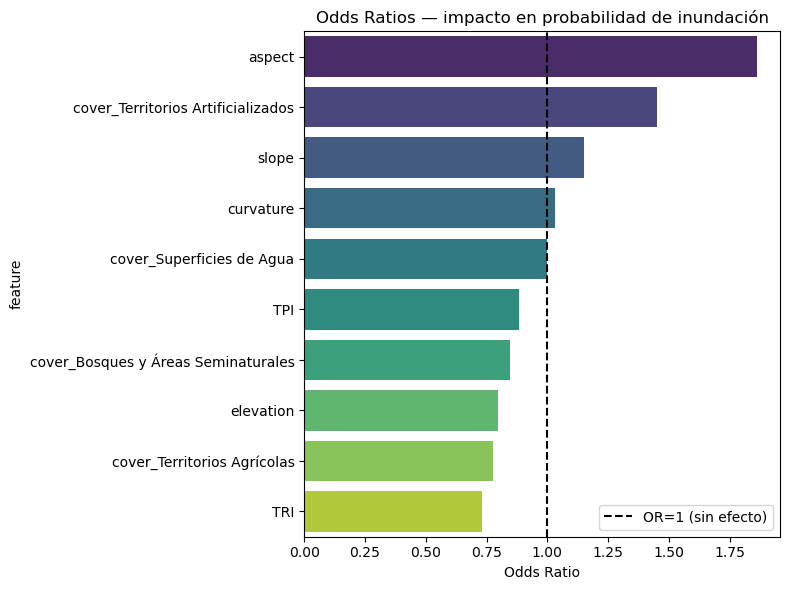

In [7]:
# ——— 1) Carga tu CSV ya preparado ———
df = pd.read_csv(r"D:\Semestre 2025-1\Analisis Geoespacial\dataset_for_logit.csv")

# ——— 2) Define explícitamente las variables continuas y las de cobertura ———
cont_vars    = ["elevation", "slope", "aspect", "curvature", "TPI", "TRI"]
dummy_vars   = [c for c in df.columns if c.startswith("cover_")]
feature_cols = cont_vars + dummy_vars

# ——— 3) Comprueba que no haya nulos en tus predictores ———
print("Nulos por variable:")
print(df[feature_cols].isna().sum(), "\n")

# ——— 4) Separa X e y ———
X = df[feature_cols]
y = df["flood"]

# ——— 5) Partición entrenamiento / test (30%) estratificando por flood ———
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# ——— 5.b) Undersampling con imblearn (ratio 1:2) ———
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)
print("Distribución en train tras undersampling 1:1:", np.bincount(y_train))

# ——— 6) Escalado de las continuas ———
scaler        = StandardScaler()
X_train_cont  = scaler.fit_transform(X_train[cont_vars])
X_test_cont   = scaler.transform(  X_test[cont_vars])

# ——— 7) Reconstruye X final ———
X_train_final = np.hstack([X_train_cont, X_train[dummy_vars].values])
X_test_final  = np.hstack([X_test_cont,  X_test[dummy_vars].values])

# ——— 8) Entrena la regresión logística ———
model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train_final, y_train)

# ——— 9) Predicción y evaluación ———
y_pred  = model.predict(X_test_final)
y_proba = model.predict_proba(X_test_final)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
# 1) Extraer coeficientes y calcular OR
# (suponiendo que ya tienes `model` entrenado y `feature_cols`)
coefs = model.coef_[0]
ors   = np.exp(coefs)

df_or = pd.DataFrame({
    'feature': feature_cols,
    'coef':    coefs,
    'odds_ratio': ors
}).sort_values('odds_ratio', ascending=False)

# 2) Gráfico de barras
plt.figure(figsize=(8,6))
sns.barplot(
    x='odds_ratio', 
    y='feature', 
    data=df_or,
    palette='viridis'
)
plt.axvline(1, color='k', linestyle='--', label='OR=1 (sin efecto)')
plt.xlabel('Odds Ratio')
plt.title('Odds Ratios — impacto en probabilidad de inundación')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# 1) Asegurémonos de que y_train arranca en 0…n-1
y_train = y_train.reset_index(drop=True)

# 2) Reconstruir DataFrame de predictores
columnas = cont_vars + dummy_vars
df_X     = pd.DataFrame(X_train_final, columns=columnas)

# 3) Eliminar predictores constantes (varianza cero)
const_cols = df_X.columns[df_X.nunique() <= 1].tolist()
if const_cols:
    df_X = df_X.drop(columns=const_cols)
    print(f"Se quitaron por varianza cero: {const_cols}")

# 4) Evitar la trampa de las dummies: quitar una dummy de cobertura
#    (elegimos la primera que aún exista en df_X)
dummy_keep = [d for d in dummy_vars if d in df_X.columns]
if dummy_keep:
    drop_dummy = dummy_keep[0]
    df_X = df_X.drop(columns=[drop_dummy])
    print(f"Se usó '{drop_dummy}' como categoría de referencia y se eliminó.")

# 5) Añadir constante (intercepto)
df_X = sm.add_constant(df_X)

# 6) Ajustar el modelo Logit en statsmodels
modelo_sm = sm.Logit(y_train, df_X).fit(disp=False)

# 7) Mostrar el resumen con coeficientes, errores estándar y p-valores
print(modelo_sm.summary2())

Se quitaron por varianza cero: ['cover_Superficies de Agua']
Se usó 'cover_Bosques y Áreas Seminaturales' como categoría de referencia y se eliminó.
                                  Results: Logit
Model:                     Logit                 Method:                MLE       
Dependent Variable:        flood                 Pseudo R-squared:      0.068     
Date:                      2025-05-26 20:20      AIC:                   795.8812  
No. Observations:          602                   BIC:                   835.4835  
Df Model:                  8                     Log-Likelihood:        -388.94   
Df Residuals:              593                   LL-Null:               -417.27   
Converged:                 1.0000                LLR p-value:           2.0903e-09
No. Iterations:            10.0000               Scale:                 1.0000    
----------------------------------------------------------------------------------
                                    Coef.  Std.Err.    

Nulos por variable:
elevation                              0
slope                                  0
curvature                              0
TPI                                    0
TRI                                    0
aspect_sin                             0
aspect_cos                             0
cover_Bosques y Áreas Seminaturales    0
cover_Superficies de Agua              0
cover_Territorios Agrícolas            0
cover_Territorios Artificializados     0
dtype: int64 

Distribución en train tras undersampling 1:1: [301 301]
              precision    recall  f1-score   support

           0       0.89      0.50      0.64       645
           1       0.22      0.70      0.33       129

    accuracy                           0.53       774
   macro avg       0.55      0.60      0.48       774
weighted avg       0.78      0.53      0.59       774

ROC AUC: 0.6401057628748272


C:\Users\Usuario\AppData\Local\Temp\ipykernel_82288\334244702.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


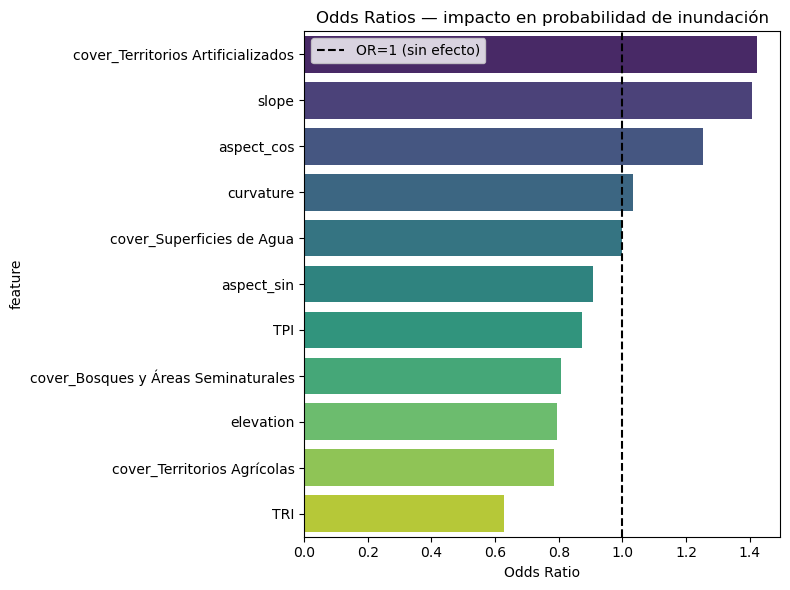

In [8]:
# ——— 1) Carga tu CSV ya preparado ———
df = pd.read_csv(r"D:\Semestre 2025-1\Analisis Geoespacial\dataset_for_logit.csv")

# 1) Convertir grados a radianes
df['aspect_rad'] = np.deg2rad(df['aspect'])

# 2) Extraer las componentes circular-lineales
df['aspect_sin'] = np.sin(df['aspect_rad'])
df['aspect_cos'] = np.cos(df['aspect_rad'])

# 3) Ya no necesitamos el aspect original ni aspect_rad
df.drop(columns=['aspect', 'aspect_rad'], inplace=True)

# ——— 2) Define explícitamente las variables continuas y las de cobertura ———
cont_vars = [
    "elevation",
    "slope",
    "curvature",
    "TPI",
    "TRI",
    "aspect_sin",      # la componente seno de la orientación
    "aspect_cos"       # la componente coseno de la orientación
]
dummy_vars = [c for c in df.columns if c.startswith("cover_")]
feature_cols = cont_vars + dummy_vars

# ——— 3) Comprueba que no haya nulos en tus predictores ———
print("Nulos por variable:")
print(df[feature_cols].isna().sum(), "\n")

# ——— 4) Separa X e y ———
X = df[feature_cols]
y = df["flood"]

# ——— 5) Partición entrenamiento / test (30%) estratificando por flood ———
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# ——— 5.b) Undersampling con imblearn (ratio 1:2) ———
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)
print("Distribución en train tras undersampling 1:1:", np.bincount(y_train))

# 6) Escalado de las variables continuas (StandardScaler)
scaler = StandardScaler()
X_train_cont = scaler.fit_transform(X_train[cont_vars])
X_test_cont  = scaler.transform(X_test[cont_vars])

# 7) Reconstruye X con continuas escaladas + dummies sin tocar
X_train_final = np.hstack([X_train_cont, X_train[dummy_vars].values])
X_test_final  = np.hstack([X_test_cont,  X_test[dummy_vars].values])

# 8) Entrena el modelo
model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)
model.fit(X_train_final, y_train)

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
# 1) Extraer coeficientes y calcular OR
# (suponiendo que ya tienes `model` entrenado y `feature_cols`)
coefs = model.coef_[0]
ors   = np.exp(coefs)

df_or = pd.DataFrame({
    'feature': feature_cols,
    'coef':    coefs,
    'odds_ratio': ors
}).sort_values('odds_ratio', ascending=False)

# 2) Gráfico de barras
plt.figure(figsize=(8,6))
sns.barplot(
    x='odds_ratio', 
    y='feature', 
    data=df_or,
    palette='viridis'
)
plt.axvline(1, color='k', linestyle='--', label='OR=1 (sin efecto)')
plt.xlabel('Odds Ratio')
plt.title('Odds Ratios — impacto en probabilidad de inundación')
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
# 1) Asegurémonos de que y_train arranca en 0…n-1
y_train = y_train.reset_index(drop=True)

# 2) Reconstruir DataFrame de predictores
columnas = cont_vars + dummy_vars
df_X     = pd.DataFrame(X_train_final, columns=columnas)

# 3) Eliminar predictores constantes (varianza cero)
const_cols = df_X.columns[df_X.nunique() <= 1].tolist()
if const_cols:
    df_X = df_X.drop(columns=const_cols)
    print(f"Se quitaron por varianza cero: {const_cols}")

# 4) Evitar la trampa de las dummies: quitar una dummy de cobertura
#    (elegimos la primera que aún exista en df_X)
dummy_keep = [d for d in dummy_vars if d in df_X.columns]
if dummy_keep:
    drop_dummy = dummy_keep[0]
    df_X = df_X.drop(columns=[drop_dummy])
    print(f"Se usó '{drop_dummy}' como categoría de referencia y se eliminó.")

# 5) Añadir constante (intercepto)
df_X = sm.add_constant(df_X)

# 6) Ajustar el modelo Logit en statsmodels
modelo_sm = sm.Logit(y_train, df_X).fit(disp=False)

# 7) Mostrar el resumen con coeficientes, errores estándar y p-valores
print(modelo_sm.summary2())

Se quitaron por varianza cero: ['cover_Superficies de Agua']
Se usó 'cover_Bosques y Áreas Seminaturales' como categoría de referencia y se eliminó.
                                  Results: Logit
Model:                     Logit                 Method:                MLE       
Dependent Variable:        flood                 Pseudo R-squared:      0.049     
Date:                      2025-05-26 21:11      AIC:                   813.4278  
No. Observations:          602                   BIC:                   857.4304  
Df Model:                  9                     Log-Likelihood:        -396.71   
Df Residuals:              592                   LL-Null:               -417.27   
Converged:                 1.0000                LLR p-value:           4.7538e-06
No. Iterations:            5.0000                Scale:                 1.0000    
----------------------------------------------------------------------------------
                                    Coef.  Std.Err.    

Coeficientes del modelo simplificado:
elevation                            -0.248715
aspect_cos                            0.240491
cover_Territorios Artificializados    0.606453
dtype: float64
=== Evaluación modelo simplificado ===
              precision    recall  f1-score   support

           0       0.90      0.53      0.67       645
           1       0.23      0.71      0.35       129

    accuracy                           0.56       774
   macro avg       0.57      0.62      0.51       774
weighted avg       0.79      0.56      0.62       774

ROC AUC (simplificado): 0.6538188810768584


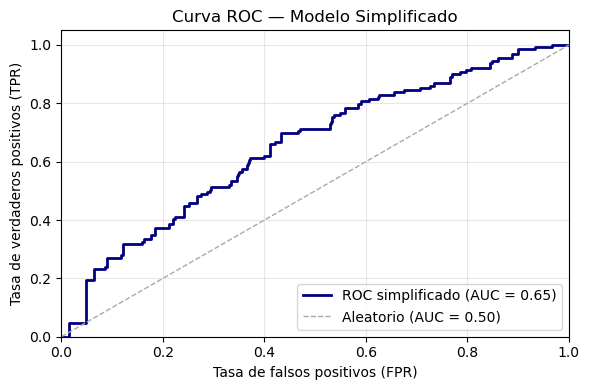

In [14]:
# ————————————————————————————————————————————————
# CELDA NUEVA: Modelo simplificado con elevation + aspect_cos + cover_Territorios Artificializados
# ————————————————————————————————————————————————

# 1) Identificar posiciones de las variables continuas escaladas
idx_elev      = cont_vars.index("elevation")
idx_aspectcos = cont_vars.index("aspect_cos")

# 2) Extraer de X_train_cont y X_test_cont las columnas correspondientes
elev_train      = X_train_cont[:, idx_elev     ].reshape(-1, 1)
aspectcos_train = X_train_cont[:, idx_aspectcos].reshape(-1, 1)

elev_test       = X_test_cont[:, idx_elev     ].reshape(-1, 1)
aspectcos_test  = X_test_cont[:, idx_aspectcos].reshape(-1, 1)

# 3) Extraer el dummy 'cover_Territorios Artificializados'
cov_train = X_train[["cover_Territorios Artificializados"]].values
cov_test  = X_test [["cover_Territorios Artificializados"]].values

# 4) Montar las matrices finales sólo con esas 3 columnas
X_train_sig = np.hstack([elev_train, aspectcos_train, cov_train])
X_test_sig  = np.hstack([elev_test,  aspectcos_test,  cov_test ])

# 5) Entrenar modelo simplificado
model_sig = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)
model_sig.fit(X_train_sig, y_train)
# Nombres en el mismo orden de tu X_train_sig
feature_names_sig = [
    "elevation",
    "aspect_cos",
    "cover_Territorios Artificializados"
]

# Crea una Serie para que sea más legible
coefs = pd.Series(model_sig.coef_[0], index=feature_names_sig)
print("Coeficientes del modelo simplificado:")
print(coefs)

# 6) Predecir y evaluar
y_pred_sig  = model_sig.predict(X_test_sig)
y_proba_sig = model_sig.predict_proba(X_test_sig)[:,1]

print("=== Evaluación modelo simplificado ===")
print(classification_report(y_test, y_pred_sig))
print("ROC AUC (simplificado):", roc_auc_score(y_test, y_proba_sig))

# 1) Calcula FPR, TPR y AUC
fpr, tpr, _ = roc_curve(y_test, y_proba_sig)
roc_auc = auc(fpr, tpr)

# 2) Dibuja la curva ROC
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='navy', lw=2,
         label=f"ROC simplificado (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color='darkgray', lw=1, linestyle='--',
         label="Aleatorio (AUC = 0.50)")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title("Curva ROC — Modelo Simplificado")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_82288\3474911601.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=or_series.values, y=or_series.index, palette="viridis")


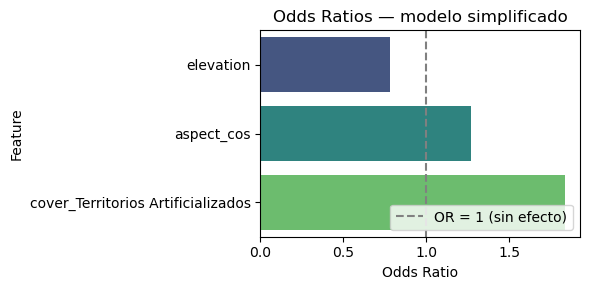

                                        coef        OR
elevation                          -0.248715  0.779802
aspect_cos                          0.240491  1.271873
cover_Territorios Artificializados  0.606453  1.833915


In [16]:
# 1) Define los nombres de las tres variables en el orden de tus coeficientes
feature_names_sig = [
    "elevation",
    "aspect_cos",
    "cover_Territorios Artificializados"
]

# 2) Extrae los coeficientes y convierte a Odds Ratios
coefs_sig = model_sig.coef_[0]
or_vals   = np.exp(coefs_sig)
or_series = pd.Series(or_vals, index=feature_names_sig)

# 3) Dibuja un barplot de los Odds Ratios
plt.figure(figsize=(6,3))
sns.barplot(x=or_series.values, y=or_series.index, palette="viridis")
plt.axvline(1, ls="--", color="gray", label="OR = 1 (sin efecto)")
plt.xlabel("Odds Ratio")
plt.ylabel("Feature")
plt.title("Odds Ratios — modelo simplificado")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# 4) Imprime la tabla de OR junto con los coeficientes originales
df_or = pd.DataFrame({
    "coef": coefs_sig,
    "OR": or_vals
}, index=feature_names_sig)
print(df_or)